# Data 512: A2 : Bias in Data

# Part 0 : Initialize variables

These variables are settings used in the rest of the notebook.

In [1]:
# folder containing the relevant data
DATA_FOLDER = './data/toxicity'

# Step 1

Here we opt to "analyze a single dataset on its own". More specifically, we'll analyze the toxicity dataset.

First let's load the data.

In [2]:
import pandas as pd
import numpy as np

#load annotated comments data
ac_df = pd.read_csv(f"{DATA_FOLDER}/toxicity_annotated_comments.tsv", sep="\t")

#load annotatations data
an_df = pd.read_csv(f"{DATA_FOLDER}/toxicity_annotations.tsv", sep="\t")

#load worker demographics data
workers_df = pd.read_csv(f"{DATA_FOLDER}/toxicity_worker_demographics.tsv", sep="\t")

## Analyze the demographic information about the Crowdflower workers that is available in the dataset
First let's take a look at the schema of the worker dataset

In [3]:
workers_df.head(1)

,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors


Let's install seaborn for some nicer visualization and plots.

In [4]:
import sys
!conda install --yes --prefix {sys.prefix} seaborn


Solving environment: ...working... done

# All requested packages already installed.



## Across different characteristics available to us (e.g., gender, english as a first language, etc.), how are workers distributed?

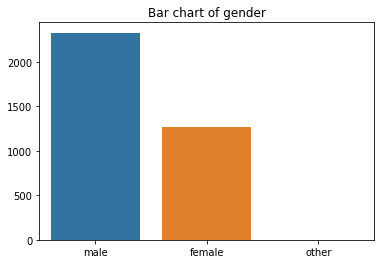

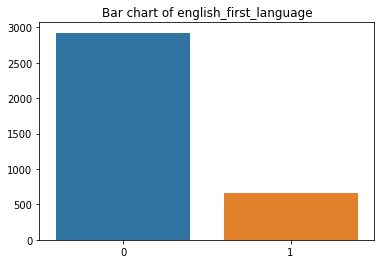

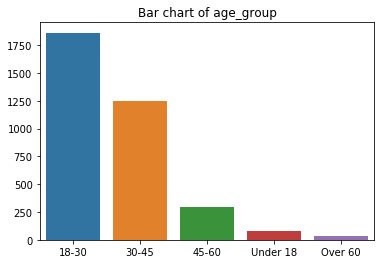

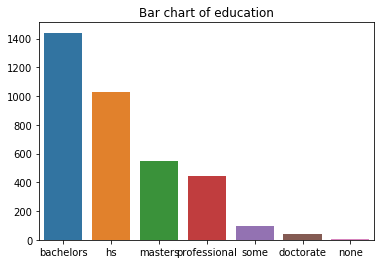

<Figure size 432x288 with 0 Axes>

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

for col in [c for c in workers_df.columns if "worker_id" != c]:
    cnt = workers_df[col].value_counts()
    sns.barplot(x=cnt.keys().values, y=cnt.values)
    title=f"Bar chart of {col}"
    plt.title(title)
    plt.show()
    plt.savefig(f"pictures/{title}.png")

Some things immediately jump out from these visuals, focusing on the general population as the general U.S. population:
<ul>
    <li>There are more males in the workers than the general population.</li>
    <li>There are less English as first-language speakers than the general population.</li>
    <li>There are more 18-30 year olds than the general population.</li>
    <li>There are more greater than high-school educated individuals than the general population.</li>
    </ul>
    
As such, due to this difference in demographic distributions, the workers may have a different sense of what messages were toxic or not than the set of individuals who aligned with the general population. 

## 	Explore relationships between worker demographics and labeling behavior

Let's join the worker metadata with the labels, to identify whether workers of different demographics are labelling datasets differently.

In [6]:
joint_df = workers_df.set_index('worker_id').join(
        an_df.set_index('worker_id'),
        how='inner'
    ).reset_index()

In [7]:
an_df.toxicity_score.unique()

array([ 0.,  1., -1.,  2., -2.])

Now let's explore whether there's differences in the percentage of toxic comments identified by different characteristics.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


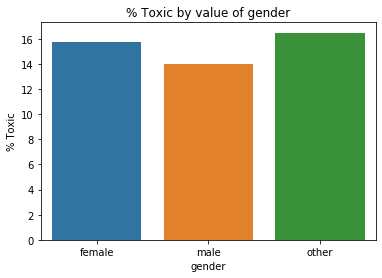

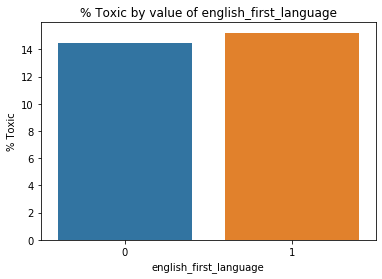

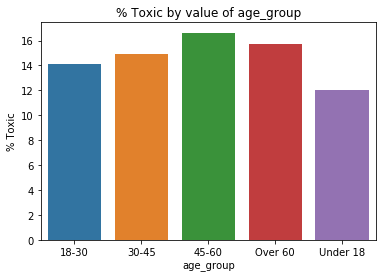

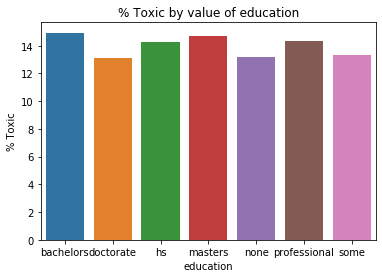

<Figure size 432x288 with 0 Axes>

In [8]:
for col in [c for c in workers_df.columns if "worker_id" != c]:
    tmp = joint_df.groupby(col)["toxicity"].agg({"Total":len, "Total Toxic": np.sum}).reset_index()
    tmp["% Toxic"] = tmp["Total Toxic"] * 100.0 / tmp["Total"]
    sns.barplot(x=tmp[col], y=tmp["% Toxic"])
    title=f"% Toxic by value of {col}"
    plt.title(title)
    plt.show()
    plt.savefig(f"pictures/{title}.png")

Atleast at a high-level, we see that there are small differences depending on the worker's charateristics in what percentage of comments were marked as toxic.
<ul>
    <li>Males identify comments as sexist at a lower rate -- maybe this is tied to potential for things such as sexism in comments.</li>
    <li>Different ages have different rates of marking comments as toxic, but younger groups tend to mark fewer comments as toxic -- maybe this is due to something like their familiarity with internet forums or cultural differences between age groups.</li>
</ul>

### What about the extremity of the values?


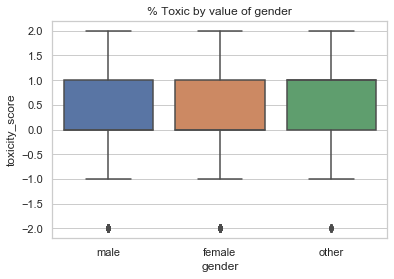

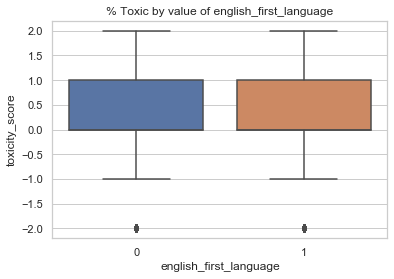

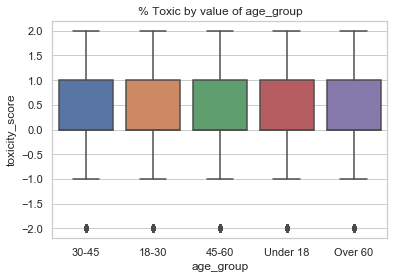

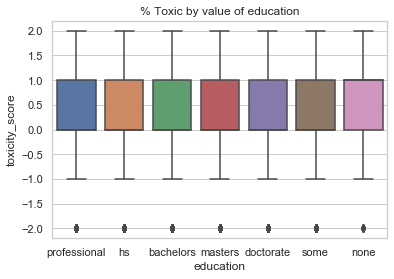

<Figure size 432x288 with 0 Axes>

In [9]:
sns.set(style="whitegrid")
for col in [c for c in workers_df.columns if "worker_id" != c]:
    sns.boxplot(data=joint_df, y="toxicity_score", x=str(col))
    title=f"% Toxic by value of {col}"
    plt.title(title)
    plt.show()
    plt.savefig(f"pictures/{title}.png")

It doesn't appear as if the toxicity score distirbution differs too much by their characteristics.

# Step 2: Discuss further implications


## Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?


I would expect it to perform reasonably on the "WikiDetox" demo application since this is the closest application to applying the model to a dataset which appears to be relatively close to the trained dataset. The other applications are pitched as general purpose solutions for other forums, but these may have different grammar and language depending on the individuals commenting on them -- making a model trained on the Wikipedia Talk corpus less relevant.

## Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

The "Hot Topics" is the demo application I would expect the Perspective API to perform the worst in. Topics which appear in the Wikipedia Talk corpus may greatly differ from other internet forums -- especially when applied to very domain-specific contexts. For example, on Reddit specific subreddits may utilize particularly technical language which is poorly identified as a topic by "Hot Topcs" if trained on only the Wikipedia Talk corpus.


## What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?

I think it would perform particularly poorly in judging the toxicity of news articles or large documents of text, since the training set sounds as if it mostly deals with forum posts. This scenario of the speech in a news article could differ vastly from the Wikipedia Talk corpus. I also suspect that it would perform poorly on dealing with racism, sexism or other forms of discrimination which may not appear explicit. This is because the training data from CrowdFlower are located all over the world and may not have familiarity with the different manners discrimination appears in language across the world.

## What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? 

I used the demo API a bit, and  the API appears to lack the ability to catch toxicity which is contextual. For example, speech supporting white supremacist groups is not registered as toxic. Strongly worded language by race is often not caught either. 

Maybe these have slipped through because the folks who have labelled the datasets were unaware or did not understand the toxicity of these statements or ideas.

## What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

The potential unintended consequences of using the Perspective API for any of these purposes is to: provide an "overconfidence" in an automated mechanism to identify toxicity (i.e.: missing toxic comments). Therefore, I would warn against relying heavily upon the tool. However, there could be potential for the tool to help capture low-hanging fruit with respect to toxicity if the users are well-trained to understand the faults and gaps of the model.

Ultimately however, there needs to be heavy user intervention when consuming the output of the model to avoid the biases of the labellers and demographics of the Wikipedia Talk Corpus from providing adverse results.

## Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?


I would consider making the following changes:
<ul>
    <li>Verify the demographics of the workers who are labelling my data and improve their diversity, if possible.</li>
    <li>Provide a detailed analysis of the potential gaps & flaws of the model and dataset in the documentation. Restrict and warn users against contexts where the model may work well, and may fail.</li>

</ul>

